# DisCoCat in DisCoPy

In the previous tutorial, we learnt the basics of monoidal categories and how to represent them in DisCoPy. In this tutorial, we look at the _Distributional Compositional Categorical_ model ([DisCoCat](https://arxiv.org/abs/1003.4394)), which uses functors to map diagrams from the [rigid category](monoidal.ipynb#Rigid-monoidal-categories) of [pregroup grammars](../string_diagrams.rst#Pregroup-grammars) to vector space semantics.

## Pregroup grammars

[Pregroup grammar](../string_diagrams.rst#Pregroup-grammars) is a grammatical formalism devised by Joachim Lambek in 1999. In pregroups, each word is a morphism with type $I \to T$ where $I$ is the monoidal unit and $T$ is a rigid type, referred to as the *pregroup type*. Here are some examples for pregroup type assignments:
* a noun is given the base type $n$.
* an adjective consumes a noun on the noun's left to return another noun, so it is given the type $n\cdot n^l$.
* a transitive verb consumes a noun on its left and another noun on its right to give a sentence, so is given the type $n^r \cdot s \cdot n^l$.

In the context of pregroups, the adjoints $n^l$ and $n^r$ can be thought of as the left and right inverses of a type $n$ respectively. In a pregroup derivation, the words are concatenated using the monoidal product $\otimes$ and linked using cups, which are special morphisms that exist in any rigid category. A sentence is grammatically sound if its derivation has a single uncontracted sentence wire.

In DisCoPy, words are defined using the [Word](https://discopy.readthedocs.io/en/main/_autosummary/discopy.grammar.pregroup.Word.html) class. [Word](https://discopy.readthedocs.io/en/main/_autosummary/discopy.grammar.pregroup.Word.html)s are just [Box](https://discopy.readthedocs.io/en/main/_autosummary/discopy.rigid.Box.html)es where the input type is fixed to be the monoidal unit $I$ (or `Ty()`). A pregroup derivation diagram can be drawn using either the [diagram.draw()](https://discopy.readthedocs.io/en/main/_autosummary/discopy.monoidal.Diagram.html#discopy.monoidal.Diagram.draw) method or [grammar.draw(diagram)](https://discopy.readthedocs.io/en/main/_autosummary/discopy.grammar.pregroup.draw.html).

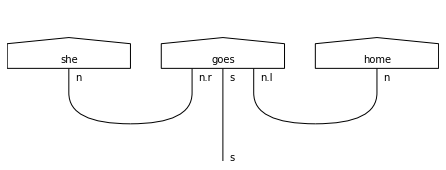

In [1]:
from discopy import grammar
from discopy.grammar import Word
from discopy.rigid import Cap, Cup, Id, Ty

n, s = Ty('n'), Ty('s')

words = [
    Word('she', n),
    Word('goes', n.r @ s @ n.l),
    Word('home', n)
]

cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

assert Id().tensor(*words) == words[0] @ words[1] @ words[2]
assert Ty().tensor(*[n.r, s, n.l]) == n.r @ s @ n.l

diagram = Id().tensor(*words) >> cups
grammar.draw(diagram)

Note that only diagrams of the form `word @ ... @ word >> cups_and_swaps` can be drawn using [grammar.draw()](https://discopy.readthedocs.io/en/main/_autosummary/discopy.grammar.pregroup.draw.html). Applying functors or normal forms will often cause the diagram to deviate from this form, in which case `diagram.draw()` should be used.

Before normal form: [Word('she', Ty('n')), Word('goes', Ty(Ob('n', z=1), 's', Ob('n', z=-1))), Word('home', Ty('n')), Cup(Ty('n'), Ty(Ob('n', z=1))), Cup(Ty(Ob('n', z=-1)), Ty('n'))]
After normal form: [Word('she', Ty('n')), Word('goes', Ty(Ob('n', z=1), 's', Ob('n', z=-1))), Cup(Ty('n'), Ty(Ob('n', z=1))), Word('home', Ty('n')), Cup(Ty(Ob('n', z=-1)), Ty('n'))]


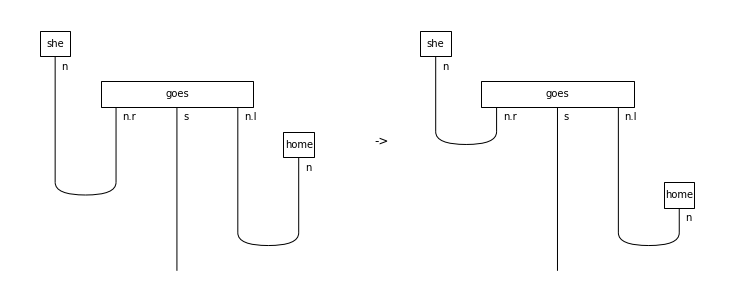

In [2]:
from discopy import drawing
from pytest import raises

# In the original diagram, words appear before the cups
print("Before normal form:", diagram.boxes)

diagram_nf = diagram.normal_form()
print("After normal form:", diagram_nf.boxes)

drawing.equation(diagram, diagram_nf, figsize=(10, 4), symbol='->')

# In the normalised diagram, boxes are not in the right order
# anymore, so cannot be drawn using grammar.draw()
with raises(ValueError):
    grammar.draw(diagram_nf)

In the example above, the application of normal form to the diagram introduces a cup before the word "twisted", so the normalised version cannot be drawn with `grammar.draw()` anymore.

## Functors

Given monoidal categories $\mathcal{C}$ and $\mathcal{D}$, a monoidal functor $F: \mathcal{C} \to \mathcal{D}$ satisfies the following properties:

- monoidal structure of objects is preserved: $F(A \otimes B) = F(A) \otimes F(B)$
- adjoints are preserved: $F(A^l) = F(A)^l$, $F(A^r) = F(A)^r$

- monoidal structure of morphism is preserved: $F(g \otimes f) = F(g) \otimes F(f)$
- compositonal structure of morphisms is preserved: $F(g \circ f) = F(g) \circ F(f)$


Put simply, a functor is a structure-preserving transformation. In a free monoidal category, applying a functor to a diagram amounts to simply providing a mapping for each generating object and morphism. In DisCoPy, a functor is defined by passing mappings (dictionaries or functions) as arguments `ob` and `ar` to the [Functor](https://discopy.readthedocs.io/en/main/_autosummary/discopy.monoidal.Functor.html) class.

Functors are one of the most powerful concepts in category theory. In fact, the encoding, rewriting and parameterisation steps of `lambeq`'s [pipeline](../pipeline.rst) are implemented individually as functors, resulting in an overall functorial transformation from parse trees to tensor networks and circuits. More specifically:

- [lambeq.ccg2discocat.CCGParser](https://cqcl.github.io/lambeq/lambeq.ccg2discocat.html#module-lambeq.ccg2discocat.ccg_parser) uses a functor (see [the related paper](https://arxiv.org/abs/2105.07720)) to transform a biclosed CCG diagram to a rigid DisCoCat diagram.
- [lambeq.rewrite.Rewriter](https://cqcl.github.io/lambeq/lambeq.html#lambeq.rewrite.Rewriter) functorially transforms a rigid DisCoCat diagram to a simpler rigid DisCoCat diagram.
- [lambeq.tensor.TensorAnsatz](https://cqcl.github.io/lambeq/lambeq.html#lambeq.tensor.TensorAnsatz) functorially transforms a rigid DisCoCat diagram to a tensor diagram, which can be evaluated as a tensor network using NumPy, JAX or PyTorch.
- [lambeq.circuit.CircuitAnsatz](https://cqcl.github.io/lambeq/lambeq.html#lambeq.circuit.CircuitAnsatz) functorially transforms a rigid DisCoCat diagram to a quantum circuit, for evaluation on a quantum device.

Below we present two examples of functors, implemented in DisCoPy.

### Example 1: "Very" functor

This functor adds the word "very" in front of every adjective in a DisCoCat diagram. 
Since the mapping is from a [rigid.Diagram](https://discopy.readthedocs.io/en/main/_autosummary/discopy.rigid.Diagram.html) to another [rigid.Diagram](https://discopy.readthedocs.io/en/main/_autosummary/discopy.rigid.Diagram.html), a [rigid.Functor](https://discopy.readthedocs.io/en/main/_autosummary/discopy.rigid.Functor.html) should be used. Further, the word "very" modifies an adjective to return another adjective, so it should have type 
$(n \otimes n^l) \otimes (n \otimes n^l)^l = n \otimes n^l \otimes n^{ll} \otimes n^l$.

In [3]:
from lambeq.ccg2discocat import DepCCGParser
parser = DepCCGParser()

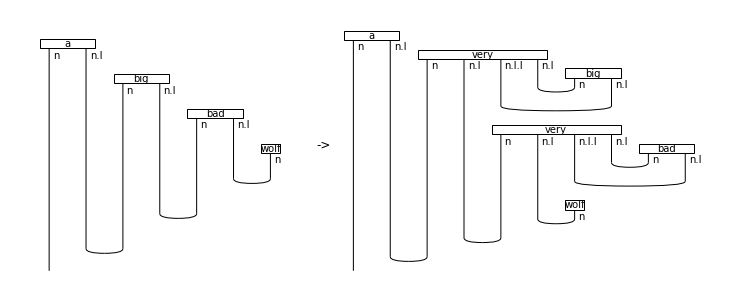

In [4]:
from discopy.rigid import Diagram, Functor

# determiners have the same type as adjectives
# but we shouldn't add 'very' behind them
determiners = ['a', 'the', 'my', 'his', 'her', 'their']

# type for an adjective
adj = n @ n.l
very = Word('very', adj @ adj.l)
cups = Diagram.cups(adj.l, adj)

def very_ob(ty):
    return ty

def very_ar(box):
    if box != very:
        if box.name not in determiners:
            if box.cod == adj:
                return very @ box >> Id(adj) @ cups
    return box

very_functor = Functor(ob=very_ob, ar=very_ar)

diagram = parser.sentence2diagram('a big bad wolf')
new_diagram = very_functor(diagram)

drawing.equation(diagram, new_diagram, figsize=(10, 4), symbol='->')

### Example 2: Twist functor


In this functor, cups and caps are treated specially and are not passed to the `ar` function; instead they are passed to methods `ar_factory.cups(left, right)` and `ar_factory.caps(left, right)`, respectively.
By default, the [rigid.Functor](https://discopy.readthedocs.io/en/main/_autosummary/discopy.rigid.Functor.html) uses [rigid.Diagram](https://discopy.readthedocs.io/en/main/_autosummary/discopy.rigid.Diagram.html) to implement the [factory pattern](https://en.wikipedia.org/wiki/Factory_method_pattern), with methods such as `cups`, `caps`, `id`, and `swap`. For example, for a functor `F` that uses the default arrow factory [Diagram](https://discopy.readthedocs.io/en/main/_autosummary/discopy.rigid.Diagram.html), `F(Cup(a, a.r)) == Diagram.cups(F(a), F(a.r))`.

Here is an example of how to map a cup to a custom diagram, such as a "twisted" cup. Note that it is up to the user to ensure the new cups and caps satisfy the snake equations.

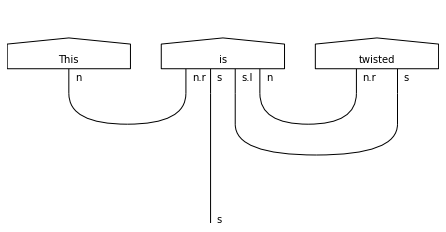

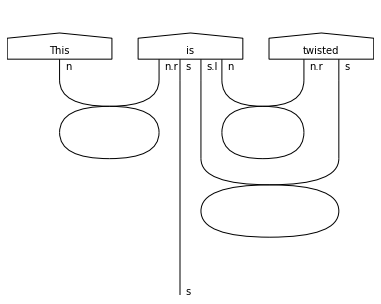

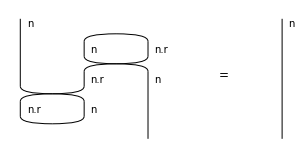

In [5]:
from discopy.rigid import Functor
from discopy import Diagram

def twist_ob(ty):
    return ty

def twist_ar(box):
    return box

class TwistedDiagram(Diagram):
    @staticmethod
    def cups(left, right):
        swaps = Diagram.swap(left, right)
        cups = Diagram.cups(right, left)
        return swaps >> cups

    @staticmethod
    def caps(left, right):
        return TwistedDiagram.cups(left, right).dagger()


twist_functor = Functor(ob=twist_ob, ar=twist_ar, ar_factory=TwistedDiagram)

diagram = parser.sentence2diagram('This is twisted')
new_diagram = twist_functor(diagram)

grammar.draw(diagram)
grammar.draw(new_diagram)

snake = Id(n) @ Cap(n.r, n) >> Cup(n, n.r) @ Id(n)
drawing.equation(twist_functor(snake), Id(n), figsize=(4, 2))

<div class="alert alert-info">

**Note**
    
Twisting the nested cups for "is" and "twisted" together is **not** a functorial operation, so it cannot be implemented using `rigid.Functor`.

</div>

## "Classical" DisCoCat: Tensor networks

The classical version of DisCoCat sends diagrams in the category of pregroup derivations to tensors in the category of vector spaces **FVect**. **FVect** is a monoidal category with vector spaces (e.g. $\mathbb{R}^2 \otimes \mathbb{R}^2$) as objects and linear maps between vector spaces as morphisms. It is in fact a _compact-closed category_, which is a special case of rigid categories where $A^l = A^r = A^*$.

Using the [discopy.tensor](https://discopy.readthedocs.io/en/main/discopy/tensor.html) module, you can define a free category of vector spaces: objects are defined with the [Dim](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Dim.html) class and morphisms with the [Box](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Box.html) class. Composite morphisms are constructed by freely combining the generating morphisms using the `<<` and `>>` operators. This is similar to how [rigid.Diagram](https://discopy.readthedocs.io/en/main/_autosummary/discopy.rigid.Diagram.html)s and [monoidal.Diagram](https://discopy.readthedocs.io/en/main/_autosummary/discopy.monoidal.Diagram.html)s are defined. The concrete value of the tensor is passed to the `data` attribute as an unshaped list; DisCoPy will reshape it later based on the input and output dimensions.

Apart of diagrams, the [discopy.tensor](https://discopy.readthedocs.io/en/main/discopy/tensor.html) module has another class that can be tensored and composed: [tensor.Tensor](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Tensor.html). The key difference is that [tensor.Box](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Box.html)es in the diagrams compose together to make [tensor.Diagram](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Diagram.html)s, while [tensor.Tensor](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Tensor.html)s compose together to make another [tensor.Tensor](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Tensor.html). In other words, [tensor.Tensor](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Tensor.html) computes tensor contractions directly, while [tensor.Diagram](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Diagram.html) delays the computation until [.eval()](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Diagram.html#discopy.tensor.Diagram.eval) is called.

Dim(1) @ Dim(2) @ Dim(3)=Dim(2, 3)


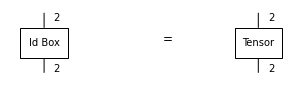

[[1 0]
 [0 1]]


In [6]:
from discopy.tensor import Box, Tensor, Id, Dim

# Dim(1) is the unit object, so disappears when tensored with another Dim
print(f'{Dim(1) @ Dim(2) @ Dim(3)=}')

id_box = Box('Id Box', Dim(2), Dim(2), data=[1,0,0,1])
id_tensor = Tensor(Dim(2), Dim(2), array=[1,0,0,1])

# the actual values of id_box and id_tensor are equal
assert (id_box.array == id_tensor.array).all()
drawing.equation(id_box, id_tensor, figsize=(4, 1))
print(id_box.array)

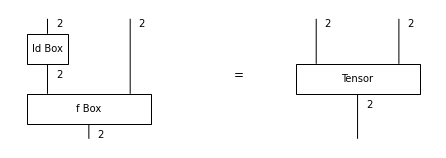

Tensor(dom=Dim(2, 2), cod=Dim(2), array=[0., 1., 2., 3., 4., 5., 6., 7.])
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]


In [7]:
f_box = Box('f Box', Dim(2, 2), Dim(2), data=range(8))
f_tensor = Tensor(Dim(2, 2), Dim(2), array=range(8))

combined_diagram = id_box @ Id(Dim(2)) >> f_box
combined_tensor = id_tensor @ Tensor.id(Dim(2)) >> f_tensor

# tensor diagram evaluates to the tensor
assert combined_diagram.eval() == combined_tensor
drawing.equation(combined_diagram, combined_tensor, figsize=(6, 2))
print(combined_tensor)
print(combined_tensor.array)

In the category of vector spaces, cups, caps and swaps take on concrete values as tensors.

In [8]:
Tensor.cups(Dim(3), Dim(3)).array

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [9]:
Tensor.swap(Dim(2), Dim(2)).array

array([[[[1., 0.],
         [0., 0.]],

        [[0., 0.],
         [1., 0.]]],


       [[[0., 1.],
         [0., 0.]],

        [[0., 0.],
         [0., 1.]]]])

To implement a functor from [rigid.Diagram](https://discopy.readthedocs.io/en/main/_autosummary/discopy.rigid.Diagram.html) to [tensor.Tensor](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Tensor.html), use a [tensor.Functor](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Functor.html). This functor will automatically contract the resulting tensor network. 

In [10]:
from discopy.tensor import Functor
import numpy as np

def one_ob(ty):
    dims = [2] * len(ty)
    return Dim(*dims) # does Dim(2,2,..)

def one_ar(box):
    dom = one_ob(box.dom)
    cod = one_ob(box.cod)
    tensor = np.ones(dom @ cod)
    print(f'"{box}" becomes')
    print(tensor)
    return tensor

one_functor = Functor(ob=one_ob, ar=one_ar)
one_functor(diagram)

"This" becomes
[1. 1.]
"is" becomes
[[[[1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]]]


 [[[1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]]]]
"twisted" becomes
[[1. 1.]
 [1. 1.]]


Tensor(dom=Dim(1), cod=Dim(2), array=[8., 8.])

Sometimes, defining a functor from [rigid.Diagram](https://discopy.readthedocs.io/en/main/_autosummary/discopy.rigid.Diagram.html) to [tensor.Diagram](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Diagram.html) offers more flexibility, since a [tensor.Diagram](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Diagram.html) can be instantiated with concrete values to be evaluated later using a custom tensor contractor. Such a functor can be defined using a [rigid.Functor](https://discopy.readthedocs.io/en/main/_autosummary/discopy.rigid.Functor.html) with [tensor.Dim](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Dim.html) and [tensor.Diagram](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Tensor.html) as `ob_factory` and `ar_factory`, respectively. See the implementation of [TensorAnsatz](https://cqcl.github.io/lambeq/_modules/lambeq/tensor.html#TensorAnsatz) for an example.

## Quantum DisCoCat: Quantum circuits

The quantum version of DisCoCat sends diagrams in the category of pregroup derivations to circuits in the category of Hilbert spaces **FHilb**. This is a compact-closed monoidal category with Hilbert spaces (e.g. $\mathbb{C}^{2^n}$) as objects and unitary maps between Hilbert spaces as morphisms.

The [discopy.quantum](https://discopy.readthedocs.io/en/main/discopy/quantum.html) module is a framework for the free category of quantum circuits: objects are generated using the [Ob](https://discopy.readthedocs.io/en/main/_autosummary/discopy.quantum.circuit.Ob.html) class and morphisms by using [quantum.gates](https://discopy.readthedocs.io/en/main/discopy/quantum.gates.html). In DiCoPy, rotation values range from $0$ to $1$ rather than from $0$ to $2\pi$. The circuit can then either be evaluated using tensor contraction with the  [.eval()](https://discopy.readthedocs.io/en/main/_autosummary/discopy.quantum.circuit.Circuit.html#discopy.quantum.circuit.Circuit.eval) method, or exported to `pytket` using the [.to_tk()](https://discopy.readthedocs.io/en/main/_autosummary/discopy.quantum.circuit.Circuit.html#discopy.quantum.circuit.Circuit.to_tk) method, which supports multiple hardware backends.


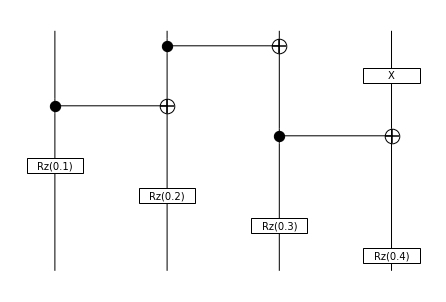

tk.Circuit(4).CX(1, 2).X(3).CX(0, 1).CX(2, 3).Rz(0.2, 0).Rz(0.4, 1).Rz(0.6, 2).Rz(0.8, 3)

In [11]:
from discopy.quantum import qubit, Id
from discopy.quantum.gates import CX, Rz, X

circuit = Id(qubit ** 4)
circuit >>= Id(qubit) @ CX @ X
circuit >>= CX @ CX
circuit >>= Rz(0.1) @ Rz(0.2) @ Rz(0.3) @ Rz(0.4)

circuit.draw()
circuit.to_tk()

To apply multi-qubit gates to non-consecutive qubits, use swaps to permute the wires, apply the gate, then unpermute the wires. These swaps are only logical swaps and do not result in more gates when converted to `tket` format.

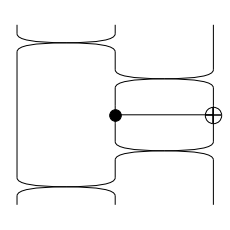

tk.Circuit(3).CX(2, 0)

In [12]:
from discopy import Circuit
from discopy.quantum.gates import Swap

# to apply a CNOT on qubits 2 and 0:
circuit1 = Id(qubit ** 3)
circuit1 >>= Swap(qubit, qubit) @ Id(qubit)
circuit1 >>= Id(qubit) @ Swap(qubit, qubit)
circuit1 >>= Id(qubit) @ CX
circuit1 >>= Id(qubit) @ Swap(qubit, qubit)
circuit1 >>= Swap(qubit, qubit) @ Id(qubit)

# or you can do
perm = Circuit.permutation([2, 0, 1])
circuit2 = perm >> Id(qubit) @ CX >> perm[::-1]

assert circuit1 == circuit2
circuit1.draw(figsize=(3, 3))

# no swaps introduced when converting to tket
circuit1.to_tk()

So far, our circuits have been "pure" circuits, consisting of unitaries. Pure circuits can be evaluated locally to return a [Tensor](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Tensor.html). Circuits containing [Discard](https://discopy.readthedocs.io/en/main/_autosummary/discopy.quantum.circuit.Discard.html)s and [Measure](https://discopy.readthedocs.io/en/main/_autosummary/discopy.quantum.circuit.Measure.html)s are considered "mixed", and return [CQMap](https://discopy.readthedocs.io/en/main/discopy/quantum.cqmap.html)s instead of [Tensor](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Tensor.html)s when evaluated, as they are not unitaries but rather classical-quantum maps. (For more details, see Chapter 5 of these [notes](http://www.cs.ox.ac.uk/people/jamie.vicary/IntroductionToCategoricalQuantumMechanics.pdf).)

In [13]:
from discopy import Discard, Measure, Ket
from discopy import C, Q

print(C(Dim(2)) @ Q(Dim(2, 3)) @ C(Dim(2)))

print(Discard().eval())
print(Measure().eval())
print(Ket(0).eval())
# circuits that have measurements in them are no longer unitary
# and return CQMaps
print((Ket(0) >> Measure()).eval())

C(Dim(2, 2)) @ Q(Dim(2, 3))
CQMap(dom=Q(Dim(2)), cod=CQ(), array=[1., 0., 0., 1.])
CQMap(dom=Q(Dim(2)), cod=C(Dim(2)), array=[1, 0, 0, 0, 0, 0, 0, 1])
Tensor(dom=Dim(1), cod=Dim(2), array=[1., 0.])
CQMap(dom=CQ(), cod=C(Dim(2)), array=[1., 0.])


Pure circuits can be coerced to evaluate into a CQMap by setting `mixed=True`.

In [14]:
CX.eval(mixed=True)

CQMap(dom=Q(Dim(2, 2)), cod=Q(Dim(2, 2)), array=[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

Note that the tensor order of CQMaps is doubled, compared to that of simple Tensors:

In [15]:
print(CX.eval().array.shape)
print(CX.eval(mixed=True).array.shape)

(2, 2, 2, 2)
(2, 2, 2, 2, 2, 2, 2, 2)


To implement a functor from [rigid.Diagram](https://discopy.readthedocs.io/en/main/_autosummary/discopy.rigid.Diagram.html) to [quantum.Circuit](https://discopy.readthedocs.io/en/main/_autosummary/discopy.quantum.Circuit.html), use a [quantum.circuit.Functor](https://discopy.readthedocs.io/en/main/_autosummary/discopy.quantum.circuit.Functor.html).

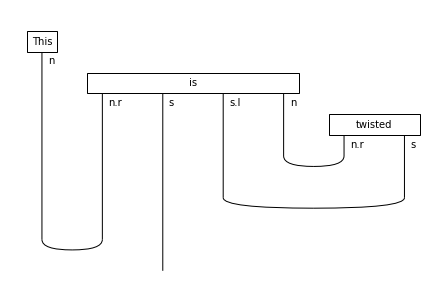

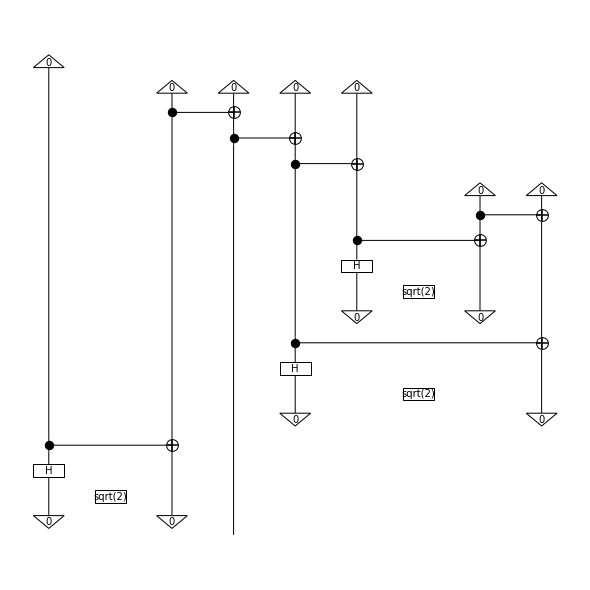

In [16]:
from discopy.quantum.circuit import Functor, Id

def cnot_ob(ty):
    # this implicitly maps all rigid types to 1 qubit
    return qubit ** len(ty)

def cnot_ar(box):
    dom = len(box.dom)
    cod = len(box.cod)
    width = max(dom, cod)
    circuit = Id(width)
    for i in range(width - 1):
        circuit >>= Id(i) @ CX @ Id(width - i - 2)

    # Add Bras (postselection) and Kets (states)
    # to get a circuit with the right amount of
    # input and output wires
    if cod <= dom:
        circuit >>= Id(cod) @ Bra(*[0]*(dom - cod))
    else:
        circuit <<= Id(dom) @ Ket(*[0]*(cod - dom))
    return circuit

cnot_functor = Functor(ob=cnot_ob, ar=cnot_ar)
diagram.draw()
cnot_functor(diagram).draw(figsize=(8, 8))